### OBJECTIVE : Apply simple control to G1 and verify mapping and observe movement in a simulation render

#### Sub Task's
* load G1 model again and **print joint + actuator lists** to confirm indexing
* Make the model stand stable and then appply the contorl to
* **pick 1 target joint** (eg. left_hip_roll) and locate its actuator index
* write a **minimal control loop** that sends a small sinus/square/constant action to that actuator
* **render short video** showing the joint moving under control
* add **notes in worklog**: mapping you used, action range tried, what looked correct/incorrect


#### Check for dm_contorl 

In [6]:
print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError('dn_contorl is not installed on the system!')
else:
  del suite, pixels
print('dm_control installation succeeded.')
     

Checking that the dm_control installation succeeded...
dm_control installation succeeded.


#### All `dm_control` import required

In [10]:
# The mujoco wrapper
from dm_control import mujoco

# Access to enums and Mujoco library functions
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib
from dm_control.mujoco.wrapper import mjbindings

####  All necassory import

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from IPython.display import clear_output
import PIL.Image
import itertools

In [12]:
import os
from pathlib import Path

project_root = Path("..").resolve()
xml_path = str(project_root / "models/G1/g1_29dof_rev_1_0.xml")

#### Example : G1 `Arm control`

In [13]:
print(f"Loading Model from path : {xml_path}")
try:
    physics = mujoco.Physics.from_xml_path(xml_path)
    print("Model Successfully loaded!")
except Exception as err:
    print(f"[ERROR] : {err}")


Loading Model from path : /home/blank/Projects/Internship/sentienc/Robotic-Simulation/robot_ws/mujoco-experiments/models/G1/g1_29dof_rev_1_0.xml
Model Successfully loaded!


#### Finding the should actuator we want to control 
*also in G1 xml files the actuator are named sames as joints for eary referecne*

In [14]:
acc_list = [physics.model.id2name(i, 'actuator') for i in range(physics.model.nu)]
print("Print List of shoulder joint")
for ls in acc_list:
    if 'shoulder_pitch' in ls:
        print(ls)

target_index = physics.model.actuator("left_shoulder_pitch_joint").id
print(id)

Print List of shoulder joint
left_shoulder_pitch_joint
right_shoulder_pitch_joint
<built-in function id>


In [15]:
def sine_contorl(physics: mujoco.Physics,amplitude = 1.0, frequncey = 5.0, ):
    return amplitude * np.sin(frequncey* physics.data.time)

#### 1. Arm movement test with gravity off

In [16]:
# simple sine control signal
def sine_control(t, amp=5.0, freq=1.0):
    return amp * np.sin(2 * np.pi * freq * t)

framerate = 30
duration = 5.0
frames = []

scene_option = mujoco.wrapper.core.MjvOption()

# simulation loop
def simulate_render_no_gravity(physics:mujoco.Physics, ctrl_fn):
    # disable gravity (temporary for mapping)
    physics.model.opt.gravity[:] = 0
    physics.reset()
    while physics.data.time < duration:
        t = physics.data.time
        physics.data.ctrl[target_index] = ctrl_fn(physics)
        physics.step()

        # collect frames
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(scene_option=scene_option)
            frames.append(pixels)

    # make video
    fig = plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000/framerate)
    plt.close()

    return HTML(anim.to_html5_video())
# simulate_render_no_gravity(physics, lambda p: sine_contorl(physics=physics))

#### Major Task Making the Model Stand  

#### Defining PD gains

In [17]:
# Stronger gain to counter gravity
Kp = 80.0
Kd = 10.0

In [18]:
# DEBUG TOOL: record qpos/qvel over time for selected joints
class JointLogger:
    def __init__(self, physics, joint_names):
        self.physics = physics
        self.joint_ids = [physics.model.joint(j).id for j in joint_names]
        self.joint_names = joint_names
        self.time_log = []
        self.qpos_log = {j: [] for j in joint_names}
        self.qvel_log = {j: [] for j in joint_names}

    def record(self):
        t = self.physics.data.time
        self.time_log.append(t)
        for name, jid in zip(self.joint_names, self.joint_ids):
            self.qpos_log[name].append(float(self.physics.data.qpos[jid]))
            self.qvel_log[name].append(float(self.physics.data.qvel[jid]))

    def plot(self):
        import matplotlib.pyplot as plt
        # qpos
        plt.figure(figsize=(10,5))
        for name in self.joint_names:
            plt.plot(self.time_log, self.qpos_log[name], label=name)
        plt.title("qpos over time")
        plt.legend(); plt.show()
        # qvel
        plt.figure(figsize=(10,5))
        for name in self.joint_names:
            plt.plot(self.time_log, self.qvel_log[name], label=name)
        plt.title("qvel over time")
        plt.legend(); plt.show()


#### joints to stabilize (legs + waist)
1. skip both arms, because posture hold is for torso + legs

In [19]:
stabilize_joints_names = [
    "waist_yaw_joint",
    "waist_roll_joint",
    "waist_pitch_joint",
    "left_hip_pitch_joint",
    "left_knee_joint",
    "left_ankle_pitch_joint",
    "right_hip_pitch_joint",
    "right_knee_joint",
    "right_ankle_pitch_joint"
]

2. Find the index for the joint i need to stabblize

In [20]:
stabilize_joints_ids = []
for joint_name in stabilize_joints_names:
    try:
        actuator_id_list = physics.model.actuator(joint_name).id
        stabilize_joints_ids.append(actuator_id_list)
    except:
        print(f"[ERROR]: ID not found for {joint_name}")
print("Successfully found necassory ID's")

Successfully found necassory ID's


In [21]:
# neutral target posture: zero for all stabilized joints
# when assuimng that neutral is same every joint
# neutral_pos = 0.0 

# per-joint neutral pose (standing bend)
neutral_pos = {
    "waist_yaw_joint":   0.0,
    "waist_roll_joint":  0.0,

    "waist_pitch_joint": 0.0,
    
    "left_hip_pitch_joint":  0.15,
    "left_knee_joint":      0.5,
    "left_ankle_pitch_joint": -0.25,

    "right_hip_pitch_joint":  0.15,
    "right_knee_joint":      0.5,
    "right_ankle_pitch_joint": -0.25,
}


3 . Making PD contorler for stablizing joint

In [22]:
def pd_hold(physics, actuator_id, _netural_pos = neutral_pos, _kd = Kd, _kp = Kp):
    # Actuator object
    actuator = physics.model.actuator(actuator_id)
    joint_id = actuator.trnid[0]

    joint = physics.data.joint(joint_id)

    joint_data = physics.data.joint(joint_id)
    joint_name = joint.name

    target = _netural_pos[joint_name]
    pos = joint_data.qpos[0]
    vel = joint_data.qvel[0]
    tau_pd = _kp * (target - pos) - _kd* vel
    tau_grav = joint_data.qfrc_bias[0]
    tau = tau_grav + tau_pd
    tau = np.clip(tau, -50.0, 50.0)
    return tau

4. Defining a simulation and render pipeline

In [35]:

logger = JointLogger(physics, stabilize_joints_names)
def simulate_render(physics, ctrl_fn, act_id_list, target_act_id):
    # simulation + rendering
    framerate = 25
    duration = 4.0
    frames = []

    scene_option = mujoco.wrapper.core.MjvOption()

    physics.reset()
    while physics.data.time < duration:
        physics.step()     
        logger.record()   

        # PD posture hold for stabilized joints
        for aid in act_id_list:
            physics.data.ctrl[aid] = ctrl_fn(physics, aid)

        # control signal for target arm joint
        # physics.data.ctrl[target_act_id] = sine_contorl(physics)

        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(scene_option=scene_option)
            frames.append(pixels)

    # -----------------------------------------
    # make video
    fig = plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]
    

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000/framerate)
    plt.close()
    logger.plot()
    
    anim
    return HTML(anim.to_html5_video())

5.1 Result for simulation using PD contorl and no arm contorl at 24 frame per sec 

#### Debugging logs

In [36]:
# Find out what DOF 10 is
def debug_out(id):
    print(f"DOF 10 joint name: {physics.model.joint(id).name}")
    print(f"DOF 10 joint type: {physics.model.joint(id).type}")

    # Check all your controlled joints
    print("\n=== Controlled Actuators ===")
    for aid in stabilize_joints_ids:
        joint_id = physics.model.actuator_trnid[aid][0]
        joint_name = physics.model.joint(joint_id).name
        print(f"Actuator {aid} -> Joint {joint_id}: {joint_name}")
        
    # Check if DOF 10 is being controlled
    print(f"\n=== Is DOF 10 in your control list? ===")
    print(f"DOF 10 in stabilize_joints_ids: {id in [physics.model.actuator_trnid[aid][0] for aid in stabilize_joints_ids]}")

    # Check your gains
    print(f"\n=== Current Gains ===")
    print(f"Kp = {Kp}")
    print(f"Kd = {Kd}")

    # Check neutral positions
    print(f"\n=== Neutral Positions ===")
    for joint_name, target in neutral_pos.items():
        print(f"{joint_name}: {target}")
debug_out(3)

DOF 10 joint name: left_hip_yaw_joint
DOF 10 joint type: [3]

=== Controlled Actuators ===
Actuator 12 -> Joint 13: waist_yaw_joint
Actuator 13 -> Joint 14: waist_roll_joint
Actuator 14 -> Joint 15: waist_pitch_joint
Actuator 0 -> Joint 1: left_hip_pitch_joint
Actuator 3 -> Joint 4: left_knee_joint
Actuator 4 -> Joint 5: left_ankle_pitch_joint
Actuator 6 -> Joint 7: right_hip_pitch_joint
Actuator 9 -> Joint 10: right_knee_joint
Actuator 10 -> Joint 11: right_ankle_pitch_joint

=== Is DOF 10 in your control list? ===
DOF 10 in stabilize_joints_ids: False

=== Current Gains ===
Kp = 80.0
Kd = 10.0

=== Neutral Positions ===
waist_yaw_joint: 0.0
waist_roll_joint: 0.0
waist_pitch_joint: 0.0
left_hip_pitch_joint: 0.15
left_knee_joint: 0.5
left_ankle_pitch_joint: -0.25
right_hip_pitch_joint: 0.15
right_knee_joint: 0.5
right_ankle_pitch_joint: -0.25


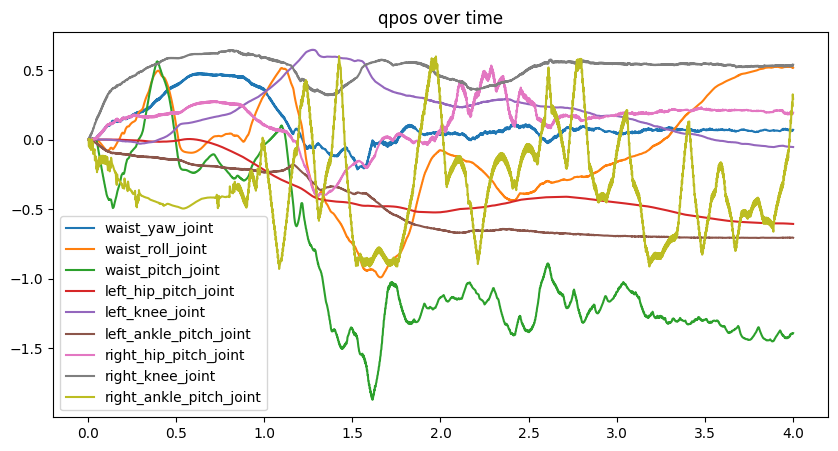

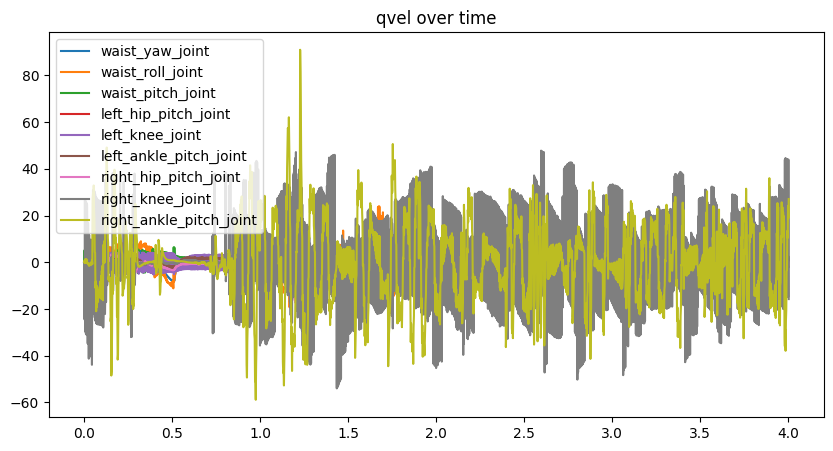

In [37]:
simulate_render(physics, lambda physics, ids: pd_hold(physics=physics, actuator_id=ids), stabilize_joints_ids, target_index)

#### The Robot models keeps falling as the arm swing is causing a backward torque

6. Attempting to stabilize ARM to avoid back swing torque 

In [26]:

# --- choose arm joints to stabilize just enough so they don't swing ---
arm_joints = [
    "left_shoulder_pitch_joint", "left_elbow_joint",
    "right_shoulder_pitch_joint", "right_elbow_joint"
]

# --- light arm neutral pose (arms slightly down, not straight forward) ---
arm_neutral = {
    "left_shoulder_pitch_joint":  -0.4,   # move arms down
    "left_elbow_joint":           +0.3,   # slight bend
    "right_shoulder_pitch_joint": -0.4,
    "right_elbow_joint":          +0.3,
}

In [31]:
# --- light gains: just enough to stop them swinging ---
Kp_arm = 40.0
Kd_arm = 4.0

In [32]:
# --- map arm joints → actuator ids (add to your setup once) ---
arm_actuator_ids = [physics.model.actuator(j).id for j in arm_joints]

print(arm_actuator_ids)

def arm_pd_hold(physics, actuator_id, _kd_arm = Kd_arm, _kp_arm=Kp_arm):
    """ weak PD on arms so they don't yank torso backward """
    j_id = physics.model.actuator_trnid[actuator_id][0]
    j_name = physics.model.joint(j_id).name

    target = arm_neutral[j_name]
    pos = physics.data.qpos[j_id]
    vel = physics.data.qvel[j_id]

    return _kp_arm * (target - pos) - _kd_arm* vel

[15, 18, 22, 25]


In [33]:

logger = JointLogger(physics, arm_joints)
def simulate_render(physics: mujoco.Physics, ctrl_fn, arm_ctrl_fn, act_id_list, arm_actuator_ids):
    # simulation + rendering
    framerate = 25
    duration = 10.0
    frames = []

    scene_option = mujoco.wrapper.core.MjvOption()

    physics.reset()
    
    # control signal for target arm joint
    for arm_aid in arm_actuator_ids:
        physics.data.ctrl[arm_aid] = arm_ctrl_fn(physics, arm_aid)

    # PD posture hold for stabilized joints
    for aid in act_id_list:            
        physics.data.ctrl[aid] = ctrl_fn(physics, aid)

    while physics.data.time < duration:   
        logger.record()
        physics.step() 

        # UPDATE CONTROL FOR NEXT STEP
        for arm_aid in arm_actuator_ids:
            physics.data.ctrl[arm_aid] = arm_ctrl_fn(physics, arm_aid)
        for aid in act_id_list:
            physics.data.ctrl[aid] = ctrl_fn(physics, aid) 

        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(scene_option=scene_option)
            frames.append(pixels)

    # -----------------------------------------
    # make video
    fig = plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]
    

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000/framerate)
    plt.close()
    logger.plot()
    
    anim
    return HTML(anim.to_html5_video())

In [38]:
debug_out(0)

DOF 10 joint name: floating_base_joint
DOF 10 joint type: [0]

=== Controlled Actuators ===
Actuator 12 -> Joint 13: waist_yaw_joint
Actuator 13 -> Joint 14: waist_roll_joint
Actuator 14 -> Joint 15: waist_pitch_joint
Actuator 0 -> Joint 1: left_hip_pitch_joint
Actuator 3 -> Joint 4: left_knee_joint
Actuator 4 -> Joint 5: left_ankle_pitch_joint
Actuator 6 -> Joint 7: right_hip_pitch_joint
Actuator 9 -> Joint 10: right_knee_joint
Actuator 10 -> Joint 11: right_ankle_pitch_joint

=== Is DOF 10 in your control list? ===
DOF 10 in stabilize_joints_ids: False

=== Current Gains ===
Kp = 80.0
Kd = 10.0

=== Neutral Positions ===
waist_yaw_joint: 0.0
waist_roll_joint: 0.0
waist_pitch_joint: 0.0
left_hip_pitch_joint: 0.15
left_knee_joint: 0.5
left_ankle_pitch_joint: -0.25
right_hip_pitch_joint: 0.15
right_knee_joint: 0.5
right_ankle_pitch_joint: -0.25


In [34]:
simulate_render(physics, lambda physics, ids: pd_hold(physics=physics, actuator_id=ids), lambda physics, ids: arm_pd_hold(physics, ids), stabilize_joints_ids, arm_actuator_ids)

PhysicsError: Physics state is invalid. Warning(s) raised: mjWARN_BADQACC